# Table of Contents
- [Objective](#objective)
- [Data processing](#data_process)
- [Build and train CNN](#build_and_train_cnn)
- [Predict using model](#predict_cnn)

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools
import os
import shutil
import random
from random import randint
import glob

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# check if tensorflow is identifying gpu, uncomment if using gpu
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("Num GPUs Available: " , len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
print(os.getcwd())

/Users/mherarabian/Desktop/ml_projects/face-mask-detection


<a id='objective'></a> 
# Objective
Build and train a **Convolutional Neural Network** using Tensorflow's Keras API that can classify images of people by detecting face masks. The goal is to train a NN model that can take an image of a person, and identify if they are wearing a face-mask.

The model should classify images as either "mask" or "no-mask".

<a id='data_process'></a> 
# Data Processing
We will go thru all the **image preparation and processing** steps needed to train our **convolutional neural network**. 

First thing we need to do is to get and prepare out data set for which we will be training our model.
The data set we’ll use is from the Kaggle [Face Mask Detection Dataset](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

Download the dataset from Kaggle [here](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset). Our raw dataset contains 6,024 total images (in .png .jpg .jpeg formats) found under directory *data/medical_masks/images*. The first 1800 images are not labeled, and should be used for the **test set**. The remaining 4,224 can be used for **training** and **validation sets**. <br>
Lets take a look at the .csv file provided...

## Image processing using `split.py`

### Load csv data

In [6]:
df = pd.read_csv('data/train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

In the dataframe below, each sample has a: 

- **name** - these are the names of the images in our dataset.
- **x1, x2, y1, y2** - [bounding box](https://medium.com/anolytics/the-use-of-bounding-boxes-in-image-annotation-for-object-detection-6371711eabba) coordinates, we will ignore these.
- **classname** - one of 20 possible classes: hijab_niqab, mask_colorful, mask_surgical, face_no_mask, face_with_mask_incorrect, face_with_mask, face_other_covering, scarf_bandana, balaclava_ski_mask, face_shield, other, gas_mask, turban, helmet, sunglasses, eyeglasses, hair_net, hat, goggles, hood.

We will use this data to construct new images using the script `split.py`

In [ ]:
# Check out a few rows of the dataframe
print(df.shape)
df.head()

### Run script `split.py` to generate images and place them in train, valid, test directories

Run the script found in the project directory called `split.py`. This script takes 5 arguments: The path to raw image data, the path to the csv above, % for training set, % for validation set, % for test. This script uses the bounding box data provided in the dataset to construct new images of mask, no-mask which it places in **train/**, **valid/**, and **test**/ directories. The percentages specify the ratio of the split for each dataset.

## Image processing using Keras

In [18]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

### Put images into [Keras Data Generator](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) format
[More on Data Generators](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)
This will basically create batches of data from the directories where our datasets reside. These batches of data will be able to be passed to the Sequential model using the **fit** function.

The only preprocessing applied to the images is the same preprocessing step used by the popular [vgg16](https://neurohive.io/en/popular-networks/vgg16/) image classifier CNN model Article on the popular image classifier CNN model.

We are storing the image data in a **Keras Sequence**, specifically a **DirectoryIterator**, using the ImageDataGenerator.flow_from_directory() function. This function generates/feeds batches of image data from the specified location on disk.

In [19]:
# preprocessing_function applies some type of preprocessing on the images, we are processing them
# in such a way that is equivalent to the way vgg16 does.
# Basically we're processing our images in the same format as which images that get pased to 
# vgg16 are processed

# flow from directory - passes in our image directory on disk, target_size is height and width we want
# our images to be resized to. Classes specify are datasets label

# shuffle=False because when we use our batches for inference, we want to look at the results in a confusion matrix
# so we need to access the unshuffled labels for our test set. we want our training and validation batches shuffed

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['mask', 'no-mask'], batch_size=10, shuffle=False)

Found 4600 images belonging to 2 classes.
Found 862 images belonging to 2 classes.
Found 287 images belonging to 2 classes.


In [20]:
assert train_batches.n == 4600 
assert valid_batches.n == 862 
assert test_batches.n == 287 
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

### Grab a single batch of images and corresponding labels from our training batches
Since our batch size is 10, this should be 10 images along with 10 corresponing labels. Lets print some of these images using this function pulled directly from [Tensorflow's website](https://www.tensorflow.org/tutorials/images/classification#visualize_training_images).

In [21]:
imgs, labels = next(train_batches)

In [22]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

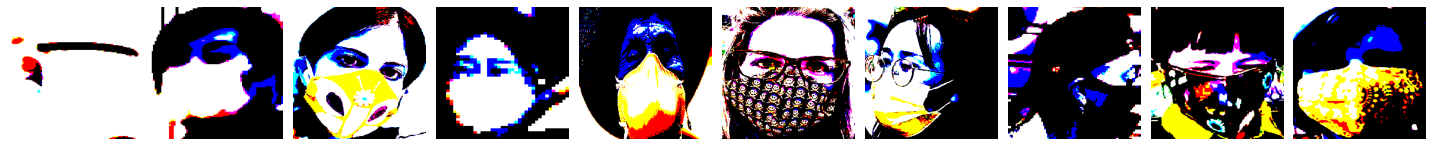

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [23]:
plotImages(imgs)
print(labels)

As seen above, the labels are [one-hot encoded](https://deeplizard.com/learn/video/v_4KWmkwmsU) vectors that represent either mask or no-mask. A [1, 0] represents **mask**, and a [0, 1] represents **no-mask**.

<a id='build_and_train_cnn'></a>
# Build and Train a Convolutional Neural Network

Our training data is stored in a DirectoryIterator, so we need to pass this to the **fit** function for training. With a recent update to Tensorflow, we are now required to pass in the **steps_per_epoch** param to the fit function whenever our training data is contained in an infinitely repeating dataset like with our DirectoryIterator data set. This repeatedly gives us batches whenever we call the built in python *next* function. **steps_per_epoch** should be equal to the number of steps or number of batches of samples to yield from our data set (training set) before declaring 1 epoch finished during the training process. Typically this is the **(number of samples in our training set)/batch_size**. Think of this as how many batches (of size 10) to pull from our data set (DirectoryIterator) to complete 1 epoch. This parameter is required when using a Keras sequence, like our DirectoryIterator. Also need to also specify **validation_steps** in the same way.

Whenever we call **model.predict()** for inference, now we need to specify **steps** parameter, which again is same as **steps_per_epoch** but when using it for predictions, it is the number of batches to yield from the dataset before declaring prediction round finished.

Lets create our CNN model!

In [7]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3), strides=2),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=50, activation='relu'),
    Dropout(0.1),
    Dense(units=2, activation='softmax')
])

### max pooling
Type of operation that is added to CNNs following individual convolutional layers. When added to a model, max pooling reduces the dimensionality of images by reducing the number of pixels in the output from the previous convolutional layer. When a filter convolves a given input, it gives us an output which is a matrix of pixels with the values computed during the convolutions that occured on our image.<br><br>
This is how max pooling works: we define some n x n (pool_size) as a filter for the max pooling operation (2, 2). Then we define stride, meaning by how many pixels do we want our filter to move as it slides across the image. Then we go to our convolutional output, and take the first 2 x 2 region and calculate the max value then store it. Then we move by 2 (stride), and do this repeatedly until we obtain a new representation of the image. After max pooling the dimension reduces.<br>

Why use max pooling in our network? Since it is reducing the resolution of the given output of a convolutional layer, the network will be looking at larger areas of the image at a time going forward -> reduces the amount of parameters in the network -> reduces computational load. Max pooling may also help reduce overfitting.

Intuition is that for a particular image, our network is looking to extract some particular features (numbers from MNIST dataset, so it's looking for edges, curves, circles, etc). So from the output of the convolutional layer, the higher valued pixels are the ones that are the **most** activated. So we are picking out the most activated pixels. Average pooling is another type of pooling where you take the average value for each region. It is not common practice at all to use padding on max pooling layers.

### padding 
padding='same' means our images will have 0-padding. Thus the input is padded such that the output of the convolutional layers will be the same as the input. Zero padding is a technique that allows us to preserve the original input size. This is something that we specify on a per-convolutional layer basis.

**First layer is a Conv2D layer** - standard conv layer that accepts image data, will arbitrarily have 32 filters with a kernel_size of (3,3) which is a common choice for image data. This layer is followed by **relu** activation function, and padding='same' means our images will have 0-padding, so the dimensionality of our images isn't reduced after the **convolution** operations.<br>
input_shape is to implicitly create the input layer, this param tells the model the shape of the input data. Recall during image processing we specified the target_size param as (224,224). The 3 is the color channels (rgb format).

**Then followed is a Max pooling layer** - pool size is (2,2) and stride 2, this is going to cut our image dimensions in half.

**Followed another Conv layer** - filter 64 here. General rule is to increase functions as you go into later layers.

**Another Max pooling layer** - similar to before.

**Flatten** - flatten into 1-dimensional tensor before passing it to Dense layer

**Dense output layer** - 2 nodes, corresponding to mask, no-mask

**Followed by softmax activation function** - will give us probabilities for each corresponding output

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12845120  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [39]:
# NOTE: can also use binary_crossentropy, and have 1 single output node from our model, and rather then using softmax
# following our output layer, we would use sigmoid
# These approachesa are pretty much equivalent, categorical_crossentropy and softmax is a common approach
# when you have more than 2 classes.
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# NOTE: not specifying y, because when data is stored as 
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
144/144 - 143s - loss: 1.4152 - accuracy: 0.8067 - val_loss: 0.3167 - val_accuracy: 0.8770
Epoch 2/10
144/144 - 140s - loss: 0.2919 - accuracy: 0.8654 - val_loss: 0.2657 - val_accuracy: 0.8898
Epoch 3/10
144/144 - 140s - loss: 0.2537 - accuracy: 0.8926 - val_loss: 0.2463 - val_accuracy: 0.9014
Epoch 4/10
144/144 - 146s - loss: 0.2307 - accuracy: 0.8935 - val_loss: 0.2501 - val_accuracy: 0.9107
Epoch 5/10
144/144 - 143s - loss: 0.1951 - accuracy: 0.9141 - val_loss: 0.2137 - val_accuracy: 0.9118
Epoch 6/10
144/144 - 143s - loss: 0.1725 - accuracy: 0.9267 - val_loss: 0.2127 - val_accuracy: 0.9095
Epoch 7/10
144/144 - 145s - loss: 0.1669 - accuracy: 0.9246 - val_loss: 0.2144 - val_accuracy: 0.9072
Epoch 8/10
144/144 - 145s - loss: 0.1505 - accuracy: 0.9339 - val_loss: 0.2411 - val_accuracy: 0.9211
Epoch 9/10
144/144 - 150s - loss: 0.1251 - accuracy: 0.9450 - val_loss: 0.2240 - val_accuracy: 0.9211
Epoch 10/10
144/144 - 156s - loss: 0.1139 - accuracy: 0.9520 - val_loss: 0.2287 - 

# Overfitting example - no dropout, more neurons

In [24]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3), strides=2),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    #Dropout(0.1),
    Dense(units=2, activation='softmax')
])

In [25]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 112, 112, 128)     3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               25690240  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [27]:
# NOTE: not specifying y, because when data is stored as 
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=12,
    verbose=2
)

Epoch 1/12
460/460 - 149s - loss: 1.0445 - accuracy: 0.8730 - val_loss: 0.2918 - val_accuracy: 0.8875
Epoch 2/12
460/460 - 156s - loss: 0.1526 - accuracy: 0.9428 - val_loss: 0.2803 - val_accuracy: 0.8805
Epoch 3/12
460/460 - 147s - loss: 0.1080 - accuracy: 0.9585 - val_loss: 0.2529 - val_accuracy: 0.9176
Epoch 4/12
460/460 - 154s - loss: 0.0667 - accuracy: 0.9778 - val_loss: 0.5623 - val_accuracy: 0.8503
Epoch 5/12
460/460 - 150s - loss: 0.0846 - accuracy: 0.9680 - val_loss: 0.3982 - val_accuracy: 0.8863
Epoch 6/12
460/460 - 151s - loss: 0.0594 - accuracy: 0.9793 - val_loss: 0.3288 - val_accuracy: 0.9165
Epoch 7/12
460/460 - 153s - loss: 0.0526 - accuracy: 0.9828 - val_loss: 0.3746 - val_accuracy: 0.9246
Epoch 8/12
460/460 - 147s - loss: 0.0348 - accuracy: 0.9859 - val_loss: 0.4274 - val_accuracy: 0.9153
Epoch 9/12
460/460 - 155s - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.3965 - val_accuracy: 0.9107
Epoch 10/12
460/460 - 152s - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.5644 - 

### Save model

In [41]:
# Checks first to see if file exists already.
# If not, the model is saved to disk.
import os.path
if os.path.isfile('models/mask_detection_model.h5') is False:
    model.save('models/mask_detection_model.h5')

In [39]:
os.getcwd()

'/home/marabian/Desktop/face-mask-detection'

<a id='predict_cnn'></a>
# Predictions

In [49]:
print(len(train_batches))

23
